Affine coordinate space has parrallel lines eg. cartesian coordinate space

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
from scipy.ndimage import measurements
import matplotlib.cm as cm

import sys, os

sys.path.append("../py/")
from fitEllipse import fitEllipse
from pcaRotate import *


In [2]:
def example_plot(ax, img, name,fontsize=12):
    ax.imshow(img)
    ax.locator_params(nbins=3)
    ax.set_title(name, fontsize=fontsize)
    ax.axis('off')

def showSave(im,name):
    plt.imshow(im)
    plt.savefig(name)
    plt.show()

6925


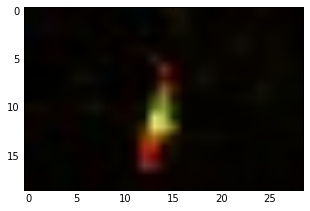

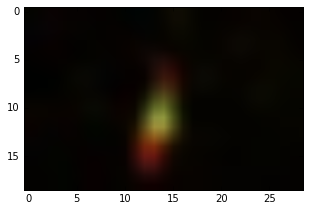

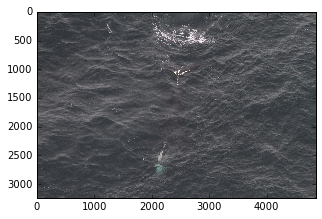

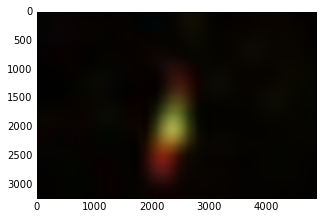

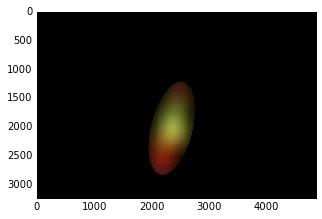

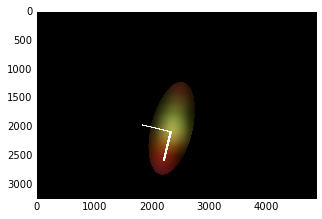

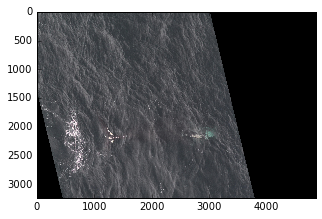

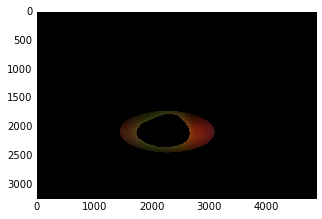

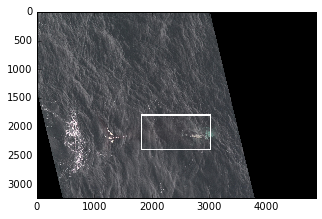

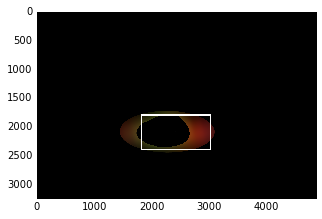

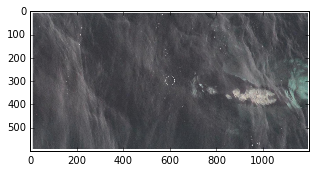

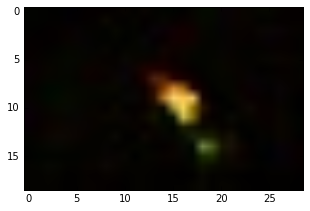

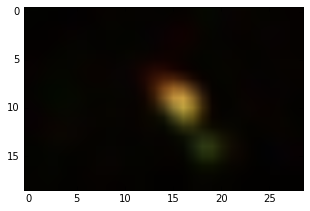

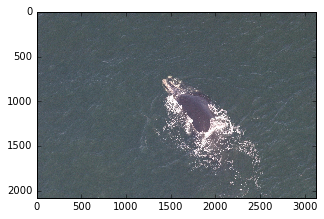

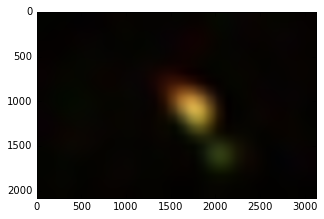

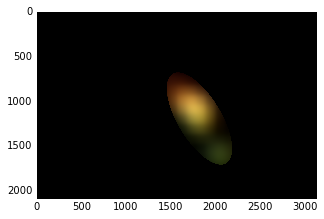

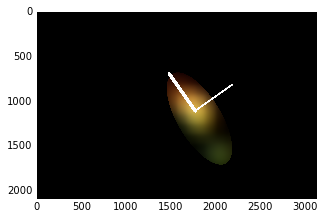

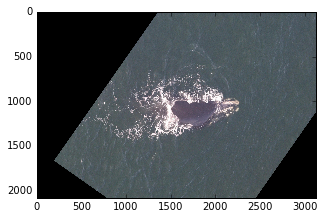

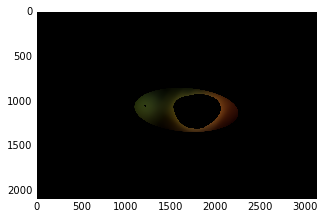

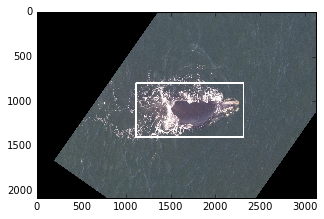

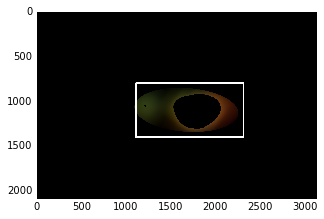

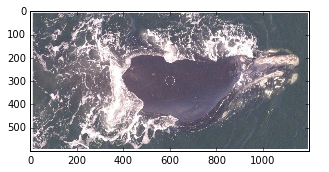

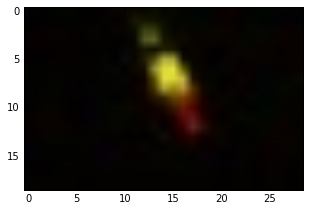

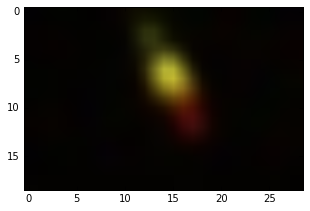

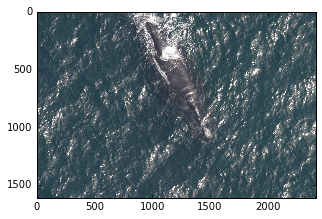

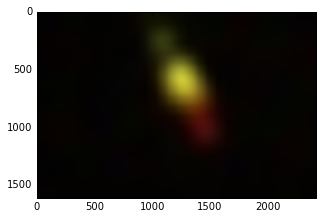

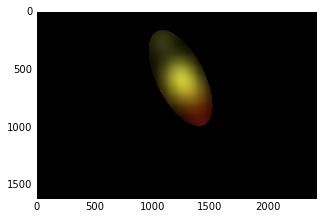

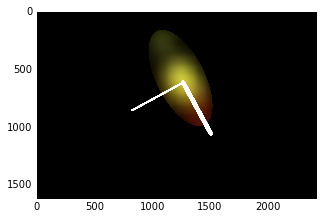

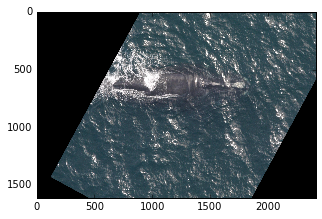

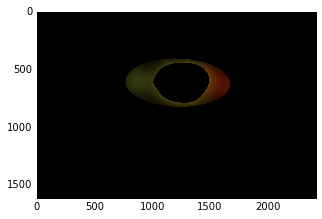

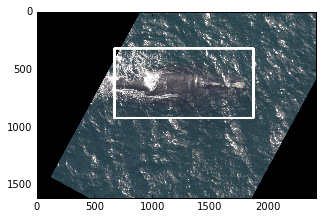

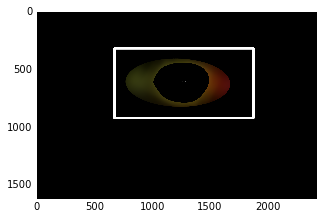

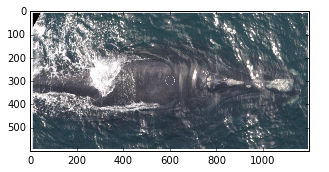

In [5]:
imgPaths = glob.glob("/home/msmith/kaggle/whale/imgs/test/m1*.jpg")
print(len(imgPaths))
name = 0
for i in np.random.permutation(len(imgPaths))[:3]:
    
    imPath = imgPaths[i]
    savePath = "examples/{0}/".format(imPath.split("/")[-1])
    if not os.path.exists(savePath):
        os.makedirs(savePath)
        
    orig = cv2.imread(imPath.replace("m1_","w1_"))[:,:,::-1]
    mask = cv2.imread(imPath.replace("m1_","m1_"))[:,:,::-1]
    
    showSave(mask,savePath+"mask.jpg")
    mask = cv2.GaussianBlur(mask,(3,3),1)
    showSave(mask,savePath+"maskBlur.jpg")
    
    h,w,c = orig.shape
    mask = cv2.resize(mask,(w,h),interpolation=cv2.INTER_CUBIC)
    
    h,w,c = mask.shape
    channel = 0 #Red
    
    showSave(orig,savePath+"orig.jpg")
    showSave(mask,savePath+"maskResize.jpg")
    
    mask = fitEllipse(mask,20,250)
    
    showSave(mask,savePath+"maskEllipse.jpg")
    centroidR, covR = getImgMoments(mask,0)
    centroidG, covG = getImgMoments(mask,1)
    e1,e2 = evs = getEigenVectors(centroid1=centroidG,centroid2=centroidR,cov=covR)

    arroLen = 500
    arrowToE1 = tuple((centroidR + (e1)*arroLen).astype(np.uint16))
    arrowToE2 = tuple((centroidR + (e2)*arroLen).astype(np.uint16))
    centroidRT = totuple(centroidR)
    centroidGT = totuple(centroidG)
    #centroidRotRedT = totuple(centroidRotRed)
    
    maskEvs = mask.copy()
    cv2.line(maskEvs,centroidRT,arrowToE1,(255,255,255),40)
    cv2.line(maskEvs,centroidRT,arrowToE2,(255,255,255),20)
    #cv2.line(mask,centroidGT,centroidRT,(0,0,255),30)
    #cv2.circle(mask,centroidRT,40,(255,0,50),-1,lineType=8)
    #cv2.circle(mask,centroidRotRedT,40,(0,255,0),-1)
    showSave(maskEvs,savePath+"maskEvs.jpg")
    
    orig, mask = rotate(orig,mask,evs,centroidR)
    mask = getRed(mask,(0,60,250))
    showSave(orig,savePath+"origRotate.jpg")
    showSave(mask,savePath+"maskRotate.jpg")
        
    centroidRotRed, _ = getImgMoments(mask,0) #Redo centroid to crop head
    w = 600
    h = 300
    x,y = centroidRotRed - np.array([w,h])
    x1,y1 = centroidRotRed + np.array([w,h])
    
    
    cv2.rectangle(orig,(x,y),(x1,y1),(255,255,255),20)
    cv2.rectangle(mask,(x,y),(x1,y1),(255,255,255),20)
    cv2.circle(orig,(centroidRotRed[0],centroidRotRed[1]),20,(255,255,255))
    cv2.circle(mask,(centroidRotRed[0],centroidRotRed[1]),20,(255,255,255))
    croppedHead = orig[y:y1,x:x1]
    showSave(orig,savePath+"origRB.jpg")
    showSave(mask,savePath+"maskRB.jpg")
    showSave(croppedHead,savePath+"origCropped.jpg")
    # Call fns
    name += 1

